In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass

# for configuring connection 
from configobj import ConfigObj
import os

# local utils
import utils

%matplotlib inline

/home/alistairewj/.virtualenvs/icu-model-transfer/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create a database connection using settings from config file
config='db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con_eicu = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con_eicu = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con_eicu = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
eicu_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: alistairewj


In [3]:
# Create a database connection using settings from config file
config='db/config-mimic.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con_mimic = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con_mimic = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con_mimic = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
mimic_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: mimic
Username: alistairewj


## eICU - Random time design matrix 

In [4]:
query = eicu_schema + """
select co.*, tm.windowtime_hours
from tr_cohort co
left join tr_time_random tm
on co.patientunitstayid = tm.patientunitstayid
"""
co_eicu = pd.read_sql_query(query, con_eicu)
co_eicu.set_index('patientunitstayid', inplace=True)

co_eicu = utils.drop_patients(co_eicu)

   181 removed due to exclusion_non_adult
 16311 removed due to exclusion_bad_data
     0 removed due to exclusion_organ_donor
101010 removed due to exclusion_by_apache

107100 (53.32%) removed so far.
  extra   4924 removed due to window time.

 88835 (44.23%) - final cohort size.


In [5]:
query = eicu_schema + """
select d.*
from tr_time_random tr
inner join tr_data d
on tr.patientunitstayid = d.patientunitstayid
and d.hr <= tr.windowtime_hours
order by 1, 2
"""
df_eicu = pd.read_sql_query(query, con_eicu)

In [6]:
query = eicu_schema + """select * from tr_static_data"""
df_eicu_static = pd.read_sql_query(query, con_eicu)
df_eicu_static.set_index('patientunitstayid', inplace=True)

### Combine dataframes together and create design matrix

/home/alistairewj/.virtualenvs/icu-model-transfer/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


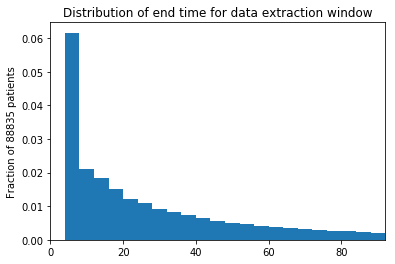

In [7]:
plt.figure()
xi = np.append(np.arange(0, 96, 4), 1000)
plt.hist(co_eicu['windowtime_hours'], bins=xi, normed=True)
plt.xlim([xi[0], xi[-2]])
plt.title('Distribution of end time for data extraction window')
plt.ylabel('Fraction of {} patients'.format(co_eicu.shape[0]))
plt.show()

In [8]:
eicu_time_dict = co_eicu['windowtime_hours'].to_dict()
X_eicu = utils.get_design_matrix(df_eicu, eicu_time_dict,
                                 pt_id_col='patientunitstayid',
                                 W=4, W_extra=24)

# add in outcomes/static vars to the design matrix
vars_static = ['death', 'ventdays',
               'is_female', 'age',
               'race_black', 'race_hispanic', 'race_asian', 'race_other',
               'electivesurgery']
X_eicu = X_eicu.merge(df_eicu_static[vars_static], how='inner',
                       left_index=True, right_index=True)

# add in hospitalid/outcomes to start of dataframe
vars_outcome = ['hospitalid', 'hosp_los']
X_eicu = co_eicu[vars_outcome].merge(X_eicu, how='inner',
              left_index=True, right_index=True)

# rearrange certain columns to beginning of dataframe
# this is only for aesthetics - nice to have non-inputs at start of df
vars_outcome = ['hospitalid', 'death', 'hosp_los', 'ventdays']
X_eicu = X_eicu[ vars_outcome + [c for c in X_eicu.columns if c not in vars_outcome] ]
X_eicu.head()

,hospitalid,death,hosp_los,ventdays,heartrate_first,sysbp_first,diasbp_first,meanbp_first,resprate_first,tempc_first,...,spo2_max,gcs_max,urineoutput_sum,is_female,age,race_black,race_hispanic,race_asian,race_other,electivesurgery
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141194,73,0,9.340972,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0,68.0,0,0,0,1,0
141203,66,0,3.957639,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1,77.0,0,0,0,1,0
141208,73,0,0.515972,0,107.0,159.0,91.0,87.0,20.0,36.9,...,95.5,13.0,0.0,1,25.0,0,0,0,1,0
141227,60,0,2.743056,2,110.0,101.0,57.0,NaN,22.0,37.9,...,97.0,NaN,400.0,0,82.0,0,0,0,1,0
141233,73,0,16.224306,2,92.0,110.0,62.0,76.0,19.0,36.4,...,100.0,15.0,1120.0,1,81.0,0,0,0,1,1


In [9]:
# write to file
X_eicu.to_csv('X_eicu.csv.gz', compression='gzip')

## MIMIC-III - Random time matrix

In [10]:
query = mimic_schema + """
select co.*, tm.windowtime_hours
from tr_cohort co
left join tr_time_random tm
on co.icustay_id = tm.icustay_id"""
co_mimic = pd.read_sql_query(query, con_mimic)
co_mimic.set_index('icustay_id', inplace=True)
co_mimic = utils.drop_patients(co_mimic)

  8109 removed due to exclusion_non_adult
  1347 removed due to exclusion_bad_data
     4 removed due to exclusion_organ_donor
 18691 removed due to exclusion_by_apache

 23825 (38.72%) removed so far.
  extra   1525 removed due to window time.

 36182 (58.80%) - final cohort size.


In [11]:
query = mimic_schema + """
select d.*
from tr_time_random tr
inner join tr_data d
on tr.icustay_id = d.icustay_id
and d.hr <= tr.windowtime_hours
order by 1, 2
"""
df_mimic = pd.read_sql_query(query, con_mimic)

In [12]:
query = mimic_schema + """select * from tr_static_data"""
df_mimic_static = pd.read_sql_query(query, con_mimic)
df_mimic_static.set_index('icustay_id', inplace=True)

### Summarize and create dataframe

/home/alistairewj/.virtualenvs/icu-model-transfer/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


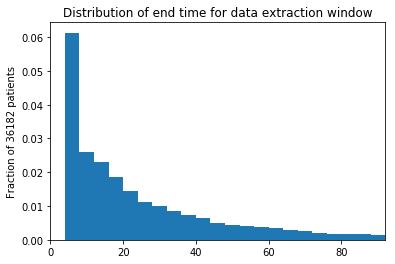

In [13]:
plt.figure()
xi = np.append(np.arange(0, 96, 4), 1000)
plt.hist(co_mimic['windowtime_hours'], bins=xi, normed=True)
plt.xlim([xi[0], xi[-2]])
plt.title('Distribution of end time for data extraction window')
plt.ylabel('Fraction of {} patients'.format(co_mimic.shape[0]))
plt.show()

In [14]:
mimic_time_dict = co_mimic['windowtime_hours'].to_dict()
X_mimic = utils.get_design_matrix(df_mimic, mimic_time_dict,
                            pt_id_col='icustay_id',
                            W=4, W_extra=24)

# add in outcomes/static vars to the design matrix
vars_static = ['death', 'ventdays',
               'is_female', 'age',
               'race_black', 'race_hispanic', 'race_asian', 'race_other',
               'electivesurgery']
X_mimic = X_mimic.merge(df_mimic_static[vars_static], how='inner',
                       left_index=True, right_index=True)

# add in hospitalid/outcomes to start of dataframe
vars_outcome = ['hospitalid', 'hosp_los']
X_mimic = co_mimic[vars_outcome].merge(X_mimic, how='inner',
              left_index=True, right_index=True)

# rearrange certain columns to beginning of dataframe
# this is only for aesthetics - nice to have non-inputs at start of df
vars_outcome = ['hospitalid', 'death', 'hosp_los', 'ventdays']
X_mimic = X_mimic[ vars_outcome + [c for c in X_mimic.columns if c not in vars_outcome] ]
X_mimic.head()

,hospitalid,death,hosp_los,ventdays,heartrate_first,sysbp_first,diasbp_first,meanbp_first,resprate_first,tempc_first,...,spo2_max,gcs_max,urineoutput_sum,is_female,age,race_black,race_hispanic,race_asian,race_other,electivesurgery
icustay_id,,,,,,,,,,,,,,,,,,,,,
200003,0,0,20.081944,4,122.0,81.0,44.0,52.000000,34.0,38.999998,...,97.0,15.0,1014.0,0,48.2940,0,0,0,0,0
200007,0,0,3.239583,0,88.0,107.0,49.0,68.333298,20.0,37.611109,...,NaN,NaN,0.0,0,43.3439,0,0,0,0,0
200009,0,0,6.177083,1,104.0,108.0,58.0,73.000000,24.0,36.900002,...,100.0,15.0,180.0,1,47.5548,0,0,0,0,1
200012,0,0,0.425694,0,103.5,99.5,72.5,78.000000,18.0,37.500000,...,99.0,15.0,650.0,1,32.9891,0,0,1,0,0
200014,0,0,4.604861,1,78.0,159.0,75.0,105.000000,16.0,NaN,...,99.0,14.0,0.0,0,84.7301,0,0,0,1,0


In [15]:
# write to file
X_mimic.to_csv('X_mimic.csv.gz', compression='gzip')

## Same as above - but 24 hour matrices

In [16]:
print('=== eICU ===')
query = eicu_schema + """
select co.*, tm.windowtime_hours
from tr_cohort co
left join tr_time_day1 tm
on co.patientunitstayid = tm.patientunitstayid
"""
co_eicu = pd.read_sql_query(query, con_eicu)
co_eicu.set_index('patientunitstayid', inplace=True)

co_eicu = utils.drop_patients(co_eicu)

query = eicu_schema + """
select d.*
from tr_time_day1 tr
inner join tr_data d
on tr.patientunitstayid = d.patientunitstayid
and d.hr <= tr.windowtime_hours
order by 1, 2
"""
df_eicu = pd.read_sql_query(query, con_eicu)

query = eicu_schema + """select * from tr_static_data"""
df_eicu_static = pd.read_sql_query(query, con_eicu)
df_eicu_static.set_index('patientunitstayid', inplace=True)

eicu_time_dict = co_eicu['windowtime_hours'].to_dict()
X_eicu = utils.get_design_matrix(df_eicu, eicu_time_dict,
                                 pt_id_col='patientunitstayid',
                                 W=24, W_extra=24)

# add in outcomes/static vars to the design matrix
vars_static = ['death', 'ventdays',
               'is_female', 'age',
               'race_black', 'race_hispanic', 'race_asian', 'race_other',
               'electivesurgery']
X_eicu = X_eicu.merge(df_eicu_static[vars_static], how='inner',
                       left_index=True, right_index=True)

# add in hospitalid/outcomes to start of dataframe
vars_outcome = ['hospitalid', 'hosp_los']
X_eicu = co_eicu[vars_outcome].merge(X_eicu, how='inner',
              left_index=True, right_index=True)

# rearrange certain columns to beginning of dataframe
# this is only for aesthetics - nice to have non-inputs at start of df
vars_outcome = ['hospitalid', 'death', 'hosp_los', 'ventdays']
X_eicu = X_eicu[ vars_outcome + [c for c in X_eicu.columns if c not in vars_outcome] ]
X_eicu.head()

# write to file
X_eicu.to_csv('X_eicu_day1.csv.gz', compression='gzip')
print('Exported {} rows to file.'.format(X_eicu.shape[0]))

=== eICU ===
   181 removed due to exclusion_non_adult
 16311 removed due to exclusion_bad_data
     0 removed due to exclusion_organ_donor
101010 removed due to exclusion_by_apache

107100 (53.32%) removed so far.
  extra  23626 removed due to window time.

 70133 (34.92%) - final cohort size.
Exported 70128 rows to file.


In [17]:
print('=== MIMIC ===')

query = mimic_schema + """
select co.*, tm.windowtime_hours
from tr_cohort co
left join tr_time_day1 tm
on co.icustay_id = tm.icustay_id"""
co_mimic = pd.read_sql_query(query, con_mimic)
co_mimic.set_index('icustay_id', inplace=True)
co_mimic = utils.drop_patients(co_mimic)

query = mimic_schema + """
select d.*
from tr_time_day1 tr
inner join tr_data d
on tr.icustay_id = d.icustay_id
and d.hr <= tr.windowtime_hours
order by 1, 2
"""
df_mimic = pd.read_sql_query(query, con_mimic)

query = mimic_schema + """select * from tr_static_data"""
df_mimic_static = pd.read_sql_query(query, con_mimic)
df_mimic_static.set_index('icustay_id', inplace=True)

# create final dataframe
mimic_time_dict = co_mimic['windowtime_hours'].to_dict()
X_mimic = utils.get_design_matrix(df_mimic, mimic_time_dict,
                            pt_id_col='icustay_id',
                            W=24, W_extra=24)

# add in outcomes/static vars to the design matrix
vars_static = ['death', 'ventdays',
               'is_female', 'age',
               'race_black', 'race_hispanic', 'race_asian', 'race_other',
               'electivesurgery']
X_mimic = X_mimic.merge(df_mimic_static[vars_static], how='inner',
                       left_index=True, right_index=True)

# add in hospitalid/outcomes to start of dataframe
vars_outcome = ['hospitalid', 'hosp_los']
X_mimic = co_mimic[vars_outcome].merge(X_mimic, how='inner',
              left_index=True, right_index=True)

# rearrange certain columns to beginning of dataframe
# this is only for aesthetics - nice to have non-inputs at start of df
vars_outcome = ['hospitalid', 'death', 'hosp_los', 'ventdays']
X_mimic = X_mimic[ vars_outcome + [c for c in X_mimic.columns if c not in vars_outcome] ]
X_mimic.head()


# write to file
X_mimic.to_csv('X_mimic_day1.csv.gz', compression='gzip')
print('Exported {} rows to file.'.format(X_mimic.shape[0]))

=== MIMIC ===
  8109 removed due to exclusion_non_adult
  1347 removed due to exclusion_bad_data
     4 removed due to exclusion_organ_donor
 18691 removed due to exclusion_by_apache

 23825 (38.72%) removed so far.
  extra   9767 removed due to window time.

 27940 (45.41%) - final cohort size.
Exported 27940 rows to file.


## Close DB connections

In [18]:
con_mimic.close()
con_eicu.close()

## Checks

In [ ]:
iid = 200033
idx = df_mimic['icustay_id'] == iid

plt.figure()
for v in ['heartrate', 'meanbp', 'resprate', 'tempc', 'spo2', 'sodium']:
    p = plt.plot( df_mimic.loc[idx, 'hr'], df_mimic.loc[idx, v], marker='.', label=v )
    col = p[0].get_color()
    
    v_to_plot = [x for x in X_mimic.columns if 'first' in x and v in x]
    plt.plot( 0, X_mimic.loc[iid, v_to_plot],
             color=col,
             markeredgecolor=col, markerfacecolor=None, marker='o',
             linewidth=4,
             markersize=10, label='_nolegend_' )
    
plt.legend(loc='upper right')
plt.title('{} window time'.format(co_mimic.loc[iid, 'windowtime_hours']))
plt.show()
#df_mimic.head()

In [ ]:
cols = ['hr', 'heartrate', 'meanbp', 'resprate', 'tempc', 'spo2', 'sodium']
cols_first = list()
for v in cols:
    cols_first.extend([x for x in X_mimic.columns if 'first' in x and v in x])
print(X_mimic.loc[iid, cols_first])

In [ ]:
df_mimic.loc[idx, cols]

In [ ]:
iid = 200033
idx = df_mimic['icustay_id'] == iid

plt.figure()
for v in ['heartrate', 'meanbp', 'resprate', 'tempc', 'spo2', 'sodium']:
    p = plt.plot( df_mimic.loc[idx, 'hr'], df_mimic.loc[idx, v], marker='.', label=v )
    col = p[0].get_color()
    
    v_to_plot = [x for x in X_mimic.columns if 'first' in x and v in x]
    plt.plot( 0, X_mimic.loc[iid, v_to_plot],
             color=col,
             markeredgecolor=col, markerfacecolor=None, marker='o',
             linewidth=4,
             markersize=10, label='_nolegend_' )
    
plt.legend(loc='upper right')
plt.title('{} window time'.format(co_mimic.loc[iid, 'windowtime_hours']))
plt.show()
#df_mimic.head()

In [ ]:
cols = ['hr', 'heartrate', 'meanbp', 'resprate', 'tempc', 'spo2', 'sodium']
cols_first = list()
for v in cols:
    cols_first.extend([x for x in X_mimic.columns if 'first' in x and v in x])
print(X_mimic.loc[iid, cols_first])

In [ ]:
df_mimic.loc[idx, cols]